In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import logging
import os

import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint
import helpers.hsql as hsql

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-c08d40e6-bcbd-4100-9e14-1252b9275c24.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4435_Add_config_to_Master_research_backtest_analyzer'
  hash='0eea161c6'
  # Last commits:
    *   0eea161c6 Nina Lee Merge branch 'master' into CmTask4435_Add_config_to_Master_research_backtest_analyzer (53 minutes ago) Thu Jun 1 06:24:39 2023  (HEAD -> CmTask4435_Add_config_to_Master_research_backtest_analyzer, origin/CmTask4435_Add_config_to_Master_research_backtest_analyzer)
    |\  
    | * cea21d7b0 Daniil Tikhom

# Build the config

In [4]:
amp_dir = hgit.get_amp_abs_path()
dir_name = os.path.join(
    amp_dir,
    "dataflow/model/test/outcomes/Test_run_master_research_backtest_analyzer/input/tiled_results",
)
config = {
    "dir_name": dir_name,
    "start_date": datetime.date(2000, 1, 1),
    "end_date": datetime.date(2000, 1, 2),
    "asset_id_col": "asset_id",
    "pnl_resampling_frequency": "5T",
    "annotate_forecasts_kwargs": {
        # "bulk_frac_to_remove": 0.0,
        # "bulk_fill_method": "zero",
        # "target_gmv": 1e6,
        # "dollar_neutrality": "gaussian_rank",
        "quantization": "nearest_share",
        "burn_in_bars": 3,
        "style": "longitudinal",
    },
    "regress_config": {
        "target_col": "prediction",
        # "feature_cols": [1, 2, 3, 4, 5, 6, "prediction"],
        "feature_cols": ["vwap.ret_0.vol_adj"],
        "feature_lag": 2,
        "batch_size": 50,
    },
    # TODO(Grisha): consider inferring column names from a `DagBuilder` object.
    "column_names": {
        "price_col": "vwap",
        "volatility_col": "vwap.ret_0.vol",
        "prediction_col": "feature1",
    },
}
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /app/amp/dataflow/model/test/outcomes/Test_run_master_research_backtest_analyzer/input/tiled_results
start_date: 2000-01-01
end_date: 2000-01-02
asset_id_col: asset_id
pnl_resampling_frequency: 5T
annotate_forecasts_kwargs: 
  quantization: nearest_share
  burn_in_bars: 3
  style: longitudinal
regress_config: 
  target_col: prediction
  feature_cols: ['vwap.ret_0.vol_adj']
  feature_lag: 2
  batch_size: 50
column_names: 
  price_col: vwap
  volatility_col: vwap.ret_0.vol
  prediction_col: feature1


# Load tiled results

## Report tile stats

In [5]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [6]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1467591036,1,1,1,13.5 KB
3303714233,1,1,1,13.5 KB


In [7]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

,,n_asset_ids,size
year,month,,
2000,1,2,26.9 KB


In [8]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1467591036, 3303714233]

## Load a single-asset tile

In [9]:
asset_batch_size = 1
cols = None
single_asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        config["dir_name"],
        asset_ids[0:1],
        config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
single_tile_df = dtfmod.process_parquet_read_df(
    single_asset_tile, config["asset_id_col"]
)

In [11]:
single_tile_df.columns.levels[0]

Index(['close', 'close.ret_0', 'feature1', 'month', 'prediction', 'twap', 'twap.ret_0', 'vwap', 'vwap.ret_0', 'vwap.ret_0.vol', 'vwap.ret_0.vol_adj', 'vwap.ret_0.vol_adj.c', 'vwap.ret_0.vol_adj.c.lag0', 'vwap.ret_0.vol_adj.c.lag1', 'vwap.ret_0.vol_adj.c.lag2', 'vwap.ret_0.vol_adj.c.lag3', 'year'], dtype='object')

In [12]:
single_tile_df.head(3)

,close,close.ret_0,feature1,month,prediction,twap,twap.ret_0,vwap,vwap.ret_0,vwap.ret_0.vol,vwap.ret_0.vol_adj,vwap.ret_0.vol_adj.c,vwap.ret_0.vol_adj.c.lag0,vwap.ret_0.vol_adj.c.lag1,vwap.ret_0.vol_adj.c.lag2,vwap.ret_0.vol_adj.c.lag3,year
asset_id,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036,1467591036
end_ts,,,,,,,,,,,,,,,,,
2000-01-01 14:31:00+00:00,101.0,NaN,1.0,1,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000
2000-01-01 14:32:00+00:00,101.0,0.0,1.0,1,NaN,101.0,0.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000
2000-01-01 14:33:00+00:00,101.0,0.0,1.0,1,NaN,101.0,0.0,101.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000


# Compute portfolio bar metrics

In [13]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    **config["column_names"],
)

In [14]:
# Create backtest dataframe tile iterator.
backtest_df_iter = dtfmod.yield_processed_parquet_tiles_by_year(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    data_cols=fep.get_cols(),
    asset_ids=None,
)
# Process the dataframes in the interator.
bar_metrics = []
for df in backtest_df_iter:
    _, bar_metrics_slice = fep.annotate_forecasts(
        df,
        # bulk_frac_to_remove=fep_config["bulk_frac_to_remove"],
        # bulk_fill_method=fep_config["bulk_fill_method"],
        # target_gmv=fep_config["target_gmv"],
        **config["annotate_forecasts_kwargs"],
    )
    bar_metrics.append(bar_metrics_slice)
bar_metrics = pd.concat(bar_metrics)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO  spread is `None`; imputing spread_lower_bound=0.000100


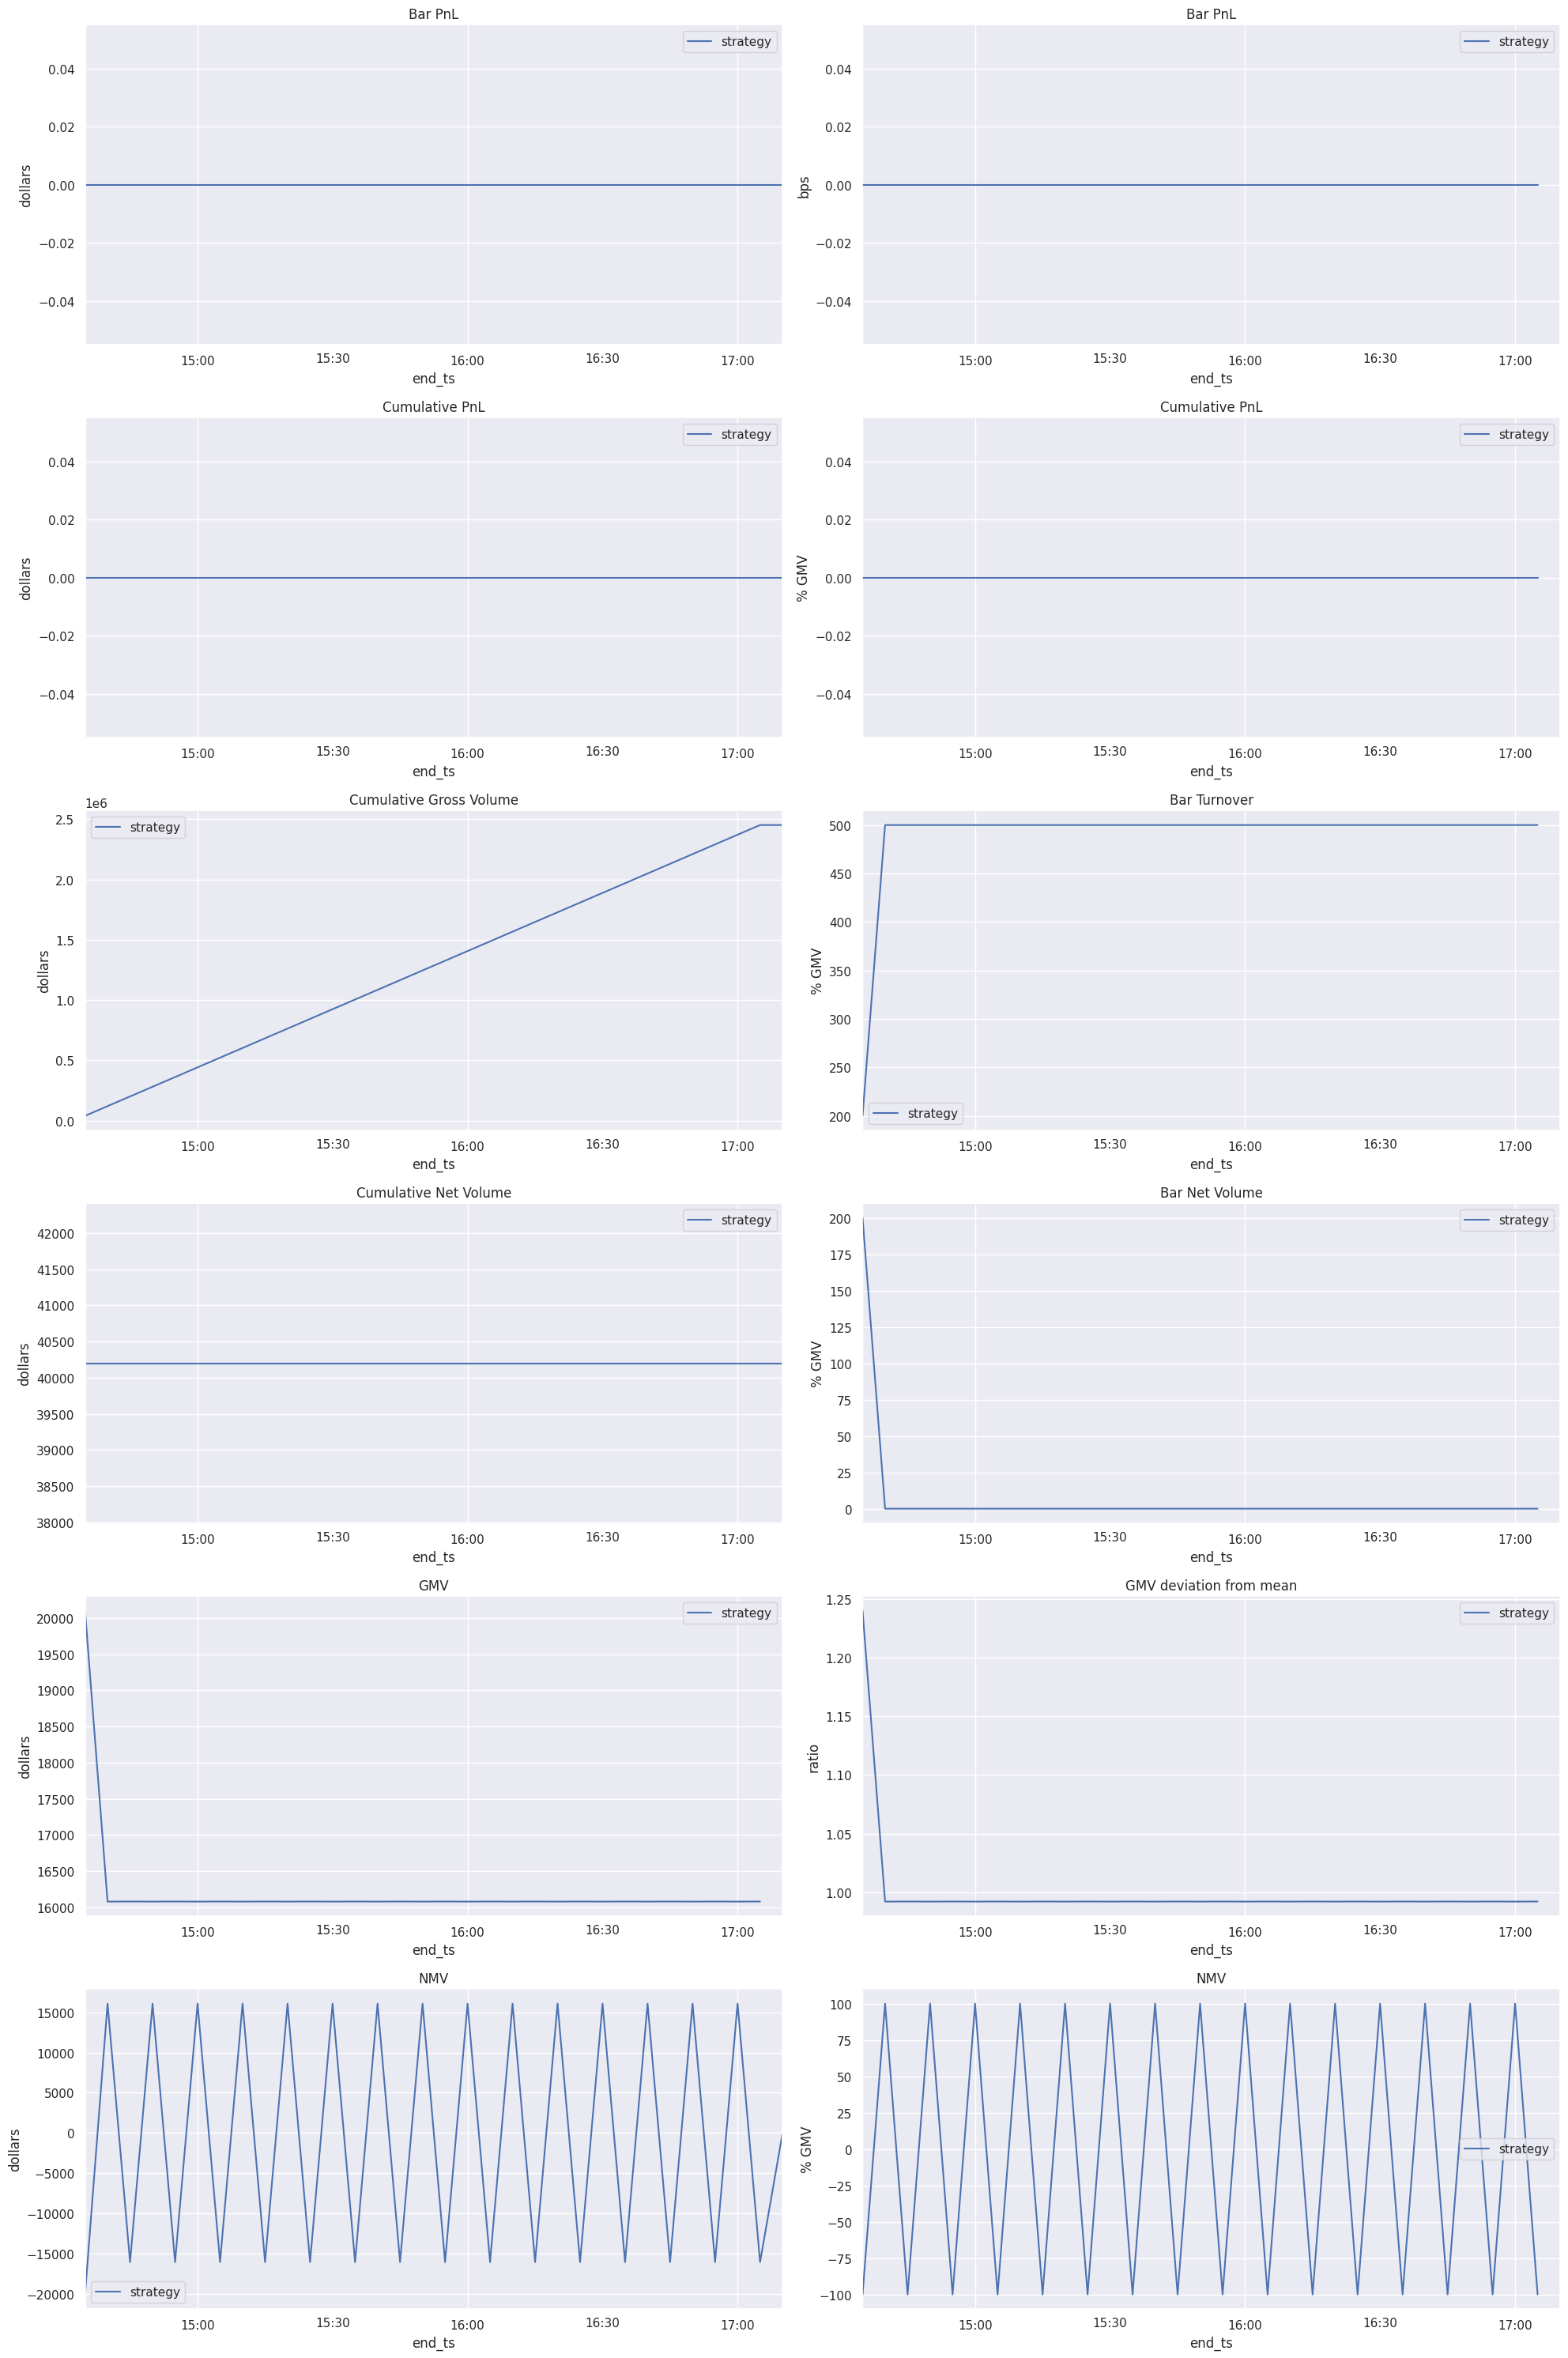

In [15]:
coplotti.plot_portfolio_stats(
    bar_metrics, freq=config["pnl_resampling_frequency"]
)

# Compute aggregate portfolio stats

In [16]:
stats_computer = dtfmod.StatsComputer()

In [17]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    bar_metrics,
    config["pnl_resampling_frequency"],
)
display(portfolio_stats)

/app/amp/core/statistics/sharpe_ratio.py:156: RuntimeWarning: invalid value encountered in double_scalars
  sr = pnl.mean() / pnl.std()
/app/amp/core/statistics/requires_statsmodels.py:42: RuntimeWarning: invalid value encountered in double_scalars
  kratio = model.params[1] / model.bse[1]


ratios      sharpe_ratio                        NaN
            sharpe_ratio_standard_error         NaN
            sr.tval                             NaN
            sr.pval                             NaN
            kratio                              NaN
dollar      gmv_mean                       15702.75
            gmv_stdev                       2952.16
            annualized_mean_return             0.00
            annualized_volatility              0.00
            max_drawdown                       0.00
            pnl_mean                           0.00
            pnl_std                            0.00
            turnover_mean                  76629.38
            turnover_stdev                 15683.60
            market_bias_mean                -628.50
            market_bias_stdev              16212.28
percentage  annualized_mean_return             0.00
            annualized_volatility              0.00
            max_drawdown                       0.00
            

# Overnight returns

In [18]:
# TODO(Grisha): consider enabling.
if False:
    # TODO(Grisha): pass params via config.
    host = ""
    dbname = ""
    port = 1000
    user = ""
    password = ""
    table_name = ""
    connection = hsql.get_connection(host, dbname, port, user, password)
    query_results = cofinanc.query_by_assets_and_dates(
        connection,
        table_name,
        asset_ids=asset_ids,
        asset_id_col=config["asset_id_col"],
        start_date=config["start_date"],
        end_date=config["end_date"],
        date_col="date",
        select_cols=[
            "date",
            "open_",
            "close",
            "total_return",
            "prev_total_return",
        ],
    )
    overnight_returns = cofinanc.compute_overnight_returns(
        query_results,
        config["asset_id_col"],
    )

# Regression analysis

In [19]:
# TODO(Grisha): consider enabling.
if False:
    coefficients, corr = dtfmod.regress(
        config["dir_name"],
        config["asset_id_col"],
        config["regress_config"]["target_col"],
        config["regress_config"]["feature_cols"],
        config["regress_config"]["feature_lag"],
        config["regress_config"]["batch_size"],
    )
    coefficients.head(3)
    corr.head()